In [2]:
# Let's import the libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#import folium
import json
#from ipywidgets import IntSlider, interact
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.decomposition import PCA
from scipy import stats
from sklearn import preprocessing
import math

In [3]:
#Load the emissions data set
total_emissions = pd.read_csv('./data/Emissions_AllAgriculture.csv', sep=',', encoding = 'latin-1')
total_emissions.columns = ('domain_code', 'domain', 'area_code','area', 'element_code','element','item_code', 'item','year_code','year','unit','value','flag', 'flag_description','note')
total_emissions.head(2)

,domain_code,domain,area_code,area,element_code,element,item_code,item,year_code,year,unit,value,flag,flag_description,note
0,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5058,Enteric Fermentation,1961,1961,gigagrams,5054.3459,A,"Aggregate, may include official, semi-official...",NaN
1,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5058,Enteric Fermentation,1962,1962,gigagrams,5151.5228,A,"Aggregate, may include official, semi-official...",NaN


In [4]:
#load the area dataset to use for normalization
total_area=pd.read_csv('./data/LandUse.csv',sep=',',encoding='latin-1')
total_area_agriculture = total_area.query("Item == 'Agriculture'")
total_area_agriculture.head(2)

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
114,RL,Land Use,2,Afghanistan,5110,Area,6602,Agriculture,1961,1961,1000 ha,37700.0,Fc,Calculated data
115,RL,Land Use,2,Afghanistan,5110,Area,6602,Agriculture,1962,1962,1000 ha,37760.0,Fc,Calculated data


In [5]:
#first join the area and emissions datasets
total_emissions = pd.merge(total_emissions, total_area_agriculture.loc[:,['Value', 'Area','Year']], left_on = ['area','year'], right_on = ['Area','Year'])
total_emissions.head(2)

,domain_code,domain,area_code,area,element_code,element,item_code,item,year_code,year,unit,value,flag,flag_description,note,Value,Area,Year
0,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5058,Enteric Fermentation,1961,1961,gigagrams,5054.3459,A,"Aggregate, may include official, semi-official...",NaN,37700.0,Afghanistan,1961
1,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5059,Manure Management,1961,1961,gigagrams,367.8310,A,"Aggregate, may include official, semi-official...",NaN,37700.0,Afghanistan,1961


In [6]:
#next normalize based on area
total_emissions['emissions_ha'] = total_emissions.value / total_emissions.Value
total_emissions.head(2)

,domain_code,domain,area_code,area,element_code,element,item_code,item,year_code,year,unit,value,flag,flag_description,note,Value,Area,Year,emissions_ha
0,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5058,Enteric Fermentation,1961,1961,gigagrams,5054.3459,A,"Aggregate, may include official, semi-official...",NaN,37700.0,Afghanistan,1961,0.134068
1,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5059,Manure Management,1961,1961,gigagrams,367.8310,A,"Aggregate, may include official, semi-official...",NaN,37700.0,Afghanistan,1961,0.009757


In [7]:
#let's check for missing values
missing_total = total_emissions[total_emissions.emissions_ha ==0].shape
total = total_emissions.shape
percent = (missing_total[0] / total[0])*100

print('There are %d values with %d equal to 0 which is %d percent'%(total[0], missing_total[0], percent))

There are 92067 values with 3157 equal to 0 which is 3 percent


In [8]:
#since we are only concerned with the fertilizer emissions, let's check how many of these are in fertilizer
emissions_fertilizer = total_emissions.query("item == 'Synthetic Fertilizers'")

emissions_missing = emissions_fertilizer[emissions_fertilizer.emissions_ha ==0].shape
emissions_total = emissions_fertilizer.shape
percent_emissions = (emissions_missing[0] / emissions_total[0])*100

print('There are %d values with %d equal to 0 which is %d percent'%(emissions_total[0], emissions_missing[0], percent_emissions))

There are 10043 values with 1153 equal to 0 which is 11 percent


In [9]:
#let's see where these missing values are coming from (which country, which years)
emissions_fertilizer[emissions_fertilizer.emissions_ha ==0].groupby('year').count().sort_values('item', ascending = False)


,domain_code,domain,area_code,area,element_code,element,item_code,item,year_code,unit,value,flag,flag_description,note,Value,Area,Year,emissions_ha
year,,,,,,,,,,,,,,,,,,
1961,46,46,46,46,46,46,46,46,46,46,46,46,0,0,46,46,46,46
1962,46,46,46,46,46,46,46,46,46,46,46,46,0,0,46,46,46,46
1963,45,45,45,45,45,45,45,45,45,45,45,45,0,0,45,45,45,45
1964,43,43,43,43,43,43,43,43,43,43,43,43,0,0,43,43,43,43
1965,43,43,43,43,43,43,43,43,43,43,43,43,0,0,43,43,43,43
1966,40,40,40,40,40,40,40,40,40,40,40,40,0,0,40,40,40,40
1967,38,38,38,38,38,38,38,38,38,38,38,38,0,0,38,38,38,38
1968,38,38,38,38,38,38,38,38,38,38,38,38,0,0,38,38,38,38
1969,36,36,36,36,36,36,36,36,36,36,36,36,0,0,36,36,36,36


We can see that the number of missing values is dramatically lower from 2002 on and not too significant in any given year. We will drop the missing values and our focus will mostly focus from 2002 onwards anyways since this is when we have other fertilizer data from.

In [10]:
emissions_fertilizer = emissions_fertilizer[(emissions_fertilizer['emissions_ha'] != 0)]

In [11]:
missing_2 = emissions_fertilizer[emissions_fertilizer.emissions_ha ==0].shape
print('There are %d values equal to 0'%(missing_2[0]))

There are 0 values equal to 0


Now let's take a look at the distribution of the data:

(array([8.876e+03, 0.000e+00, 0.000e+00, 3.000e+00, 5.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 3.000e+00]),
 array([9.62463908e-08, 2.40348920e+01, 4.80697839e+01, 7.21046757e+01,
        9.61395676e+01, 1.20174460e+02, 1.44209351e+02, 1.68244243e+02,
        1.92279135e+02, 2.16314027e+02, 2.40348919e+02]),
 <a list of 10 Patch objects>)

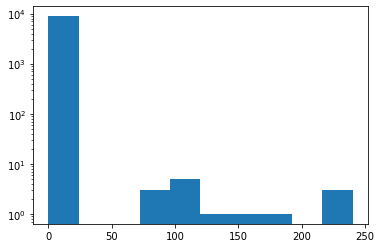

In [11]:
plt.hist(emissions_fertilizer.emissions_ha, log = True)

In [12]:
#now let's read the crops dataset
crops=pd.read_pickle("crops_interpolated")

In [13]:
# To avoid duplicated index or other index issues
crops=crops.reset_index()
crops.drop(columns=['index'],axis=1, inplace=True)
crops.head(1)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1975,1975,ha,0,F


In [14]:
# This function separate countries in three different groups according to their fertilizer emissions
def emissions_class(x, L): 
    ''' x is the emissions value, L is the set of emissions values'''
    if x<np.percentile(L,33):
        return 'low'
    elif np.percentile(L,33)<=x<np.percentile(L,66):
        return 'medium'
    else:
        return 'high'

In [46]:

def umap_year_emissions(year, n_components=2): 
    yield_for_merge=(crops.query('`Element Code` == 5419') #extraction of yield in crop dataset and pivot to have a df with each yield as a column (feature)
            .query('`Year Code` == @year')
            .query('`Item Code` >1000')
            .query('`Area Code` <300') # Exclusion of grouped areas
            .pivot(index='Area',columns='Item',values='Value')
            .drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])# drop columns with to many missing values
            .reset_index()
            
              )
    yield_for_merge['Cereal']=yield_for_merge.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)#merge strongly correlated columns
    yield_for_merge.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
    yield_for_merge=yield_for_merge.dropna(axis=0)
    yield_for_umap=yield_for_merge.drop('Area',axis=1).values 
    
    #Normalization 
    x = yield_for_umap
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    yield_for_umap = pd.DataFrame(x_scaled)
    
    reducer = umap.UMAP(random_state=1, n_components= n_components)
    embedding = reducer.fit_transform(yield_for_umap)
    embedding2=pd.DataFrame(embedding)
    embedding2=pd.merge(embedding2,yield_for_merge['Area'], left_index=True, right_index=True)
    
    #importation of emissions
    umap_emissions=(emissions_fertilizer
                    .query('Year == @year'))
    embedding2=pd.merge(embedding2,umap_emissions.loc[:,['Area','emissions_ha']],left_on='Area',right_on='Area')
    
    #Result normalization to be able to compare them between years
    embedding2[0]=(embedding2[0]-min(embedding2[0]))/(max(embedding2[0])-min(embedding2[0]))
    embedding2.rename(columns={0: "Umap"}, inplace=True)
    embedding2['emissions_ha']=(embedding2['emissions_ha']-min(embedding2['emissions_ha']))/(max(embedding2['emissions_ha'])-min(embedding2['emissions_ha']))
    embedding2['emissions_class']=embedding2.emissions_ha.apply(lambda x: emissions_class(x, embedding2.emissions_ha))
    
    coef = np.polyfit(embedding2['Umap'],embedding2.emissions_ha,1)
    
    return year,embedding2,coef # return year (for confirmation), performed umap and value of linear regression

Text(0, 0.5, 'Interpolation Coef')

<Figure size 1440x1080 with 0 Axes>

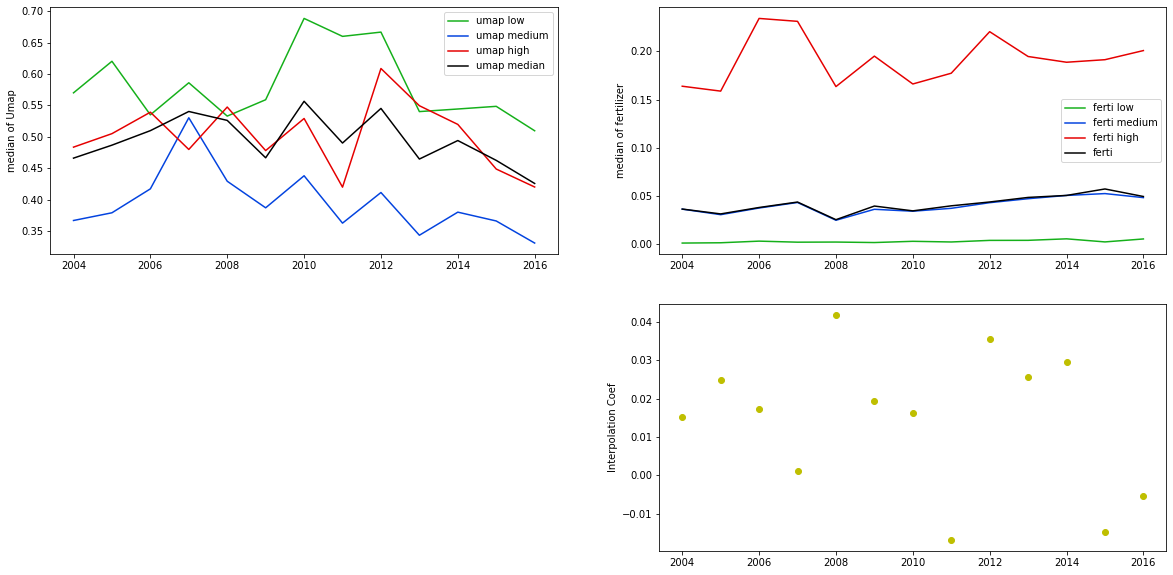

In [47]:
fig = plt.figure(figsize = (20, 15))
fig.suptitle('Evolution of the interpolation coefficient of each fertilizer over the year ', fontsize=25)

umap_plot=[]
for year in range(2004, 2017):
    umap_result=umap_year_emissions(year,1)
    low_median=umap_result[1].emissions_ha[umap_result[1].emissions_class=='low'].median()
    medium_median=umap_result[1].emissions_ha[umap_result[1].emissions_class=='medium'].median()
    high_median=umap_result[1].emissions_ha[umap_result[1].emissions_class=='high'].median()
    ferti_median=umap_result[1].emissions_ha.median()
    
    umap_low_median=umap_result[1].Umap[umap_result[1].emissions_class=='low'].median()
    umap_medium_median=umap_result[1].Umap[umap_result[1].emissions_class=='medium'].median()
    umap_high_median=umap_result[1].Umap[umap_result[1].emissions_class=='high'].median()
    umap_median=umap_result[1].Umap.median()
    
    umap_plot.append([umap_result[0],umap_result[2][0],low_median,medium_median,high_median,ferti_median,
                         umap_low_median,umap_medium_median,umap_high_median,umap_median])
    
umap_plot=pd.DataFrame(umap_plot, 
                          columns= ['Year','Coef','ferti low','ferti medium','ferti high','ferti',
                                          'umap low','umap medium','umap high','umap median'])

colors = ["green", "blue", "red"]

figure = plt.figure(figsize = (20,10))
ax1 = figure.add_subplot(2,2,1)
ax1.plot("Year", "umap low", data=umap_plot, color=sns.xkcd_palette(colors)[0])
ax1.plot("Year", "umap medium", data=umap_plot, color=sns.xkcd_palette(colors)[1])
ax1.plot("Year", "umap high", data=umap_plot, color=sns.xkcd_palette(colors)[2])
ax1.plot("Year", "umap median", data=umap_plot, color=sns.xkcd_rgb["black"])
ax1.set_ylabel('median of Umap')
ax1.legend()

ax2 = figure.add_subplot(2,2,2)
ax2.plot("Year", "ferti low", data=umap_plot, color=sns.xkcd_palette(colors)[0])
ax2.plot("Year", "ferti medium", data=umap_plot, color=sns.xkcd_palette(colors)[1])
ax2.plot("Year", "ferti high", data=umap_plot, color=sns.xkcd_palette(colors)[2])
ax2.plot("Year", "ferti", data=umap_plot, color=sns.xkcd_rgb["black"])
ax2.set_ylabel('median of fertilizer')
ax2.legend()

ax4 = figure.add_subplot(2,2,4)
ax4.plot("Year", 'Coef', 'yo', data=umap_plot)
ax4.set_ylabel('Interpolation Coef')

In [104]:
def pre_processing_PCA(df, target, features):
    # Separating out the features
    x = df.loc[:, features].values
    # Separating out the countries
    y = df.loc[:,[target]].values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)
    return x

def PCA_processing(df, target, features):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(pre_processing_PCA(df, target, features))
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])
    return pca,pd.concat([principalDf, df[[target]]], axis=1)

In [378]:
crops.head(2)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1975,1975,ha,0,F
1,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1976,1976,ha,5900,F


In [393]:
#pca for 1 year:
grouped_yield=crops.query('`Element Code` == 5419')\
.query('`Year Code` == 2016')\
.query('`Item Code` >1000')\
.query('`Area Code` <300')\
.pivot(index='Area',columns='Item',values='Value')\
.drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])\
.reset_index()


grouped_yield['Cereal']=grouped_yield.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)#merge strongly correlated columns
grouped_yield=grouped_yield.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
grouped_yield=grouped_yield.dropna(axis=0)
grouped_yield=grouped_yield.reindex()

emissions_fert_2016 = emissions_fertilizer.query("year == 2016")

pca,pca_one = PCA_processing(grouped_yield,'Area', grouped_yield.columns[1:])
pca_one=pd.merge(pca_one,emissions_fert_2016.loc[:,['Area','emissions_ha']],left_on='Area',right_on='Area')
pca_one['emissions_class']=pca_one.emissions_ha.apply(lambda x: emissions_class(x, pca_one.emissions_ha))


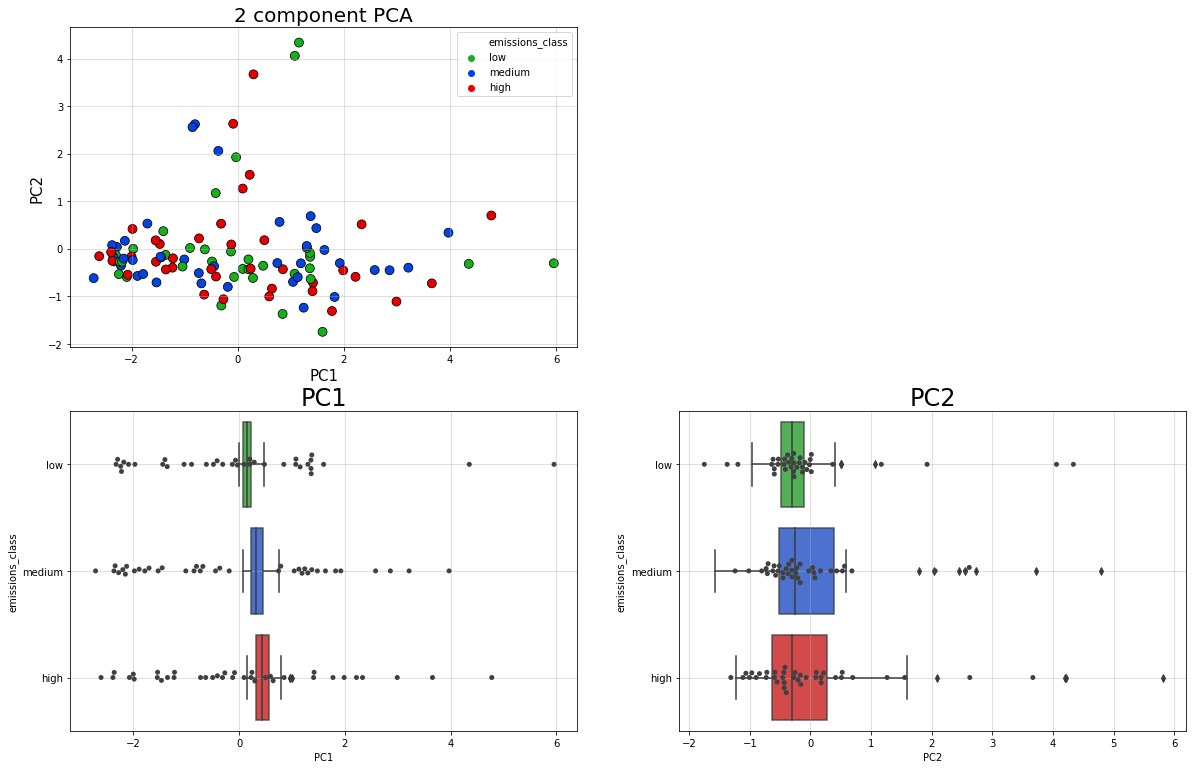

In [394]:
#Viz for 1 year 
figure = plt.figure(figsize = (20,20))
colors = ["green", "blue", "red"]

ax1 = figure.add_subplot(3,2,1)
ax1.set_xlabel('Principal Component 1', fontsize = 15)
ax1.set_ylabel('Principal Component 2', fontsize = 15)
ax1.set_title('2 component PCA', fontsize = 20)
ax1.grid(alpha=0.5)
ax1 = sns.scatterplot(x='PC1', y='PC2', hue='emissions_class', palette=sns.xkcd_palette(colors), data=pca_one, s=80,edgecolor="black")

ax2 = figure.add_subplot(3,2,3)
ax2 = sns.boxplot(x='PC1', y='emissions_class', data=grouped_yield_pca, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax2 = sns.swarmplot(x='PC1', y='emissions_class', data=pca_one, color=".25")
ax2.grid(alpha=0.5)
plt.title('PC1', fontsize=24);

ax3 = figure.add_subplot(3,2,4)
ax3 = sns.boxplot(x='PC2', y='emissions_class', data=grouped_yield_pca, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax3 = sns.swarmplot(x='PC2', y='emissions_class', data=pca_one, color=".25")
ax3.grid(alpha=0.5)
plt.title('PC2', fontsize=24);

#ax4 = figure.add_subplot(3,2,5)
#coef = np.polyfit(pca_one.PC1,pca_one.emissions_ha,1)
#poly1d_fn = np.poly1d(coef)
#plt.plot(pca_one.PC1,pca_one.emissions_ha, 'yo',pca_one.PC1, poly1d_fn(pca_one.PC1), '--k')
#ax4.set_xlabel('PC1', fontsize = 15)
#ax4.set_ylabel('Fertilizer use', fontsize = 15)

#ax5 = figure.add_subplot(3,2,6)
#coef = np.polyfit(pca_one.PC2,pca_one.emissions_ha,1)
#poly1d_fn = np.poly1d(coef)
#plt.plot(pca_one.PC2,pca_one.Value, 'yo',pca_one.PC2, poly1d_fn(pca_one.PC2), '--k')
#ax5.set_xlabel('PC2', fontsize = 15)
#ax5.set_ylabel('Fertilizer use', fontsize = 15)

In [382]:
grouped_yield.head()

Item,Area,Cereals (Rice Milled Eqv),"Cereals,Total","Coarse Grain, Total",Fruit Primary,"Oilcrops, Cake Equivalent","Oilcrops, Oil Equivalent","Pulses,Total","Roots and Tubers,Total",Vegetables Primary
0,Afghanistan,19391,19816,16667,88201,6868.33,4060.16,7406,119868,91869
1,Albania,47164,47164,54585,225650,8590.25,6390.75,13178,245894,272656
2,Algeria,10204,10204,7647,105776,10673,3412.9,9978,304431,219122
3,American Samoa,NaN,NaN,NaN,41581,2332.37,3790.24,NaN,38299,37544
4,Angola,9263,9341,9248,221661,2415.01,2342.51,4858,103597,37260


In [105]:
def PCA_year_emissions(year):

    grouped_yield=crops.query('`Element Code` == 5419')\
    .query('`Year Code` == @year')\
    .query('`Item Code` >1000')\
    .query('`Area Code` <300')\
    .pivot(index='Area',columns='Item',values='Value')\
    .drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])\
    .reset_index()

    grouped_yield['Cereal']=grouped_yield.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)#merge strongly correlated columns
    grouped_yield=grouped_yield.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
    grouped_yield=grouped_yield.dropna(axis=0)
    grouped_yield=grouped_yield.reindex()
    
    pca,grouped_yield_pca = PCA_processing(grouped_yield,'Area', grouped_yield.columns[1:])

    #importation of emissions
    pca_emissions=(emissions_fertilizer
                    .query('Year == @year'))

    grouped_yield_pca=pd.merge(grouped_yield_pca,pca_emissions.loc[:,['Area','emissions_ha']],left_on='Area',right_on='Area')
    grouped_yield_pca.dropna(axis=0, inplace=True)
    grouped_yield_pca['emissions_class']=grouped_yield_pca.emissions_ha.apply(lambda x: emissions_class(x, grouped_yield_pca.emissions_ha))
    grouped_yield_pca.PC1=(grouped_yield_pca.PC1-min(grouped_yield_pca.PC1))/(max(grouped_yield_pca.PC1)-min(grouped_yield_pca.PC1))
    grouped_yield_pca.emissions_ha=(grouped_yield_pca.emissions_ha-min(grouped_yield_pca.emissions_ha))/(max(grouped_yield_pca.emissions_ha)-min(grouped_yield_pca.emissions_ha))
    
    
    
    coef = np.polyfit(grouped_yield_pca.PC1,grouped_yield_pca.emissions_ha,1)

    return year,grouped_yield_pca,coef # return year (for confirmation), performed PCA and value of linear regression

In [374]:
years = []
PC1_low = []
PC1_medium = []
PC1_high = []
PC1 = []
ferti_low = []
ferti_medium = []
ferti_high = []
ferti = []
fertilizer_effect = []
proportion_explained = []
test = []


for year in range(2002,2016):
    years += [year]
    
    grouped_yield=crops.query('`Element Code` == 5419')\
        .query('`Year Code` == @year')\
        .query('`Item Code` >1000')\
        .query('`Area Code` <300')\
        .pivot(index='Area',columns='Item',values='Value')\
        .drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])\
        .reset_index()

    grouped_yield['Cereal']=grouped_yield.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)#merge strongly correlated columns
    grouped_yield=grouped_yield.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
    grouped_yield=grouped_yield.dropna(axis=0)
    grouped_yield=grouped_yield.reset_index()
    grouped_yield.drop(columns=['index'],inplace=True)
    
    pca,grouped_yield_pca = PCA_processing(grouped_yield,'Area', grouped_yield.columns[1:])


    #importation of emissions
    pca_emissions=(emissions_fertilizer
                    .query('Year == @year'))
    
    grouped_yield_pca=pd.merge(grouped_yield_pca,pca_emissions.loc[:,['Area','emissions_ha']],left_on='Area',right_on='Area')
    grouped_yield_pca['emissions_class']=grouped_yield_pca.emissions_ha.apply(lambda x: emissions_class(x, grouped_yield_pca.emissions_ha))
    
    PC1_low += [grouped_yield_pca.PC1[grouped_yield_pca.emissions_class=='low'].median()]
    PC1_medium += [grouped_yield_pca.PC1[grouped_yield_pca.emissions_class=='medium'].median()]
    PC1_high += [grouped_yield_pca.PC1[grouped_yield_pca.emissions_class=='high'].median()]
    PC1 += [grouped_yield_pca.PC1.median()]
    #test += [grouped_yield_pca.PC1.median()/emissions_ha.median()]
    
    
    #print(len(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='low']),len(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='medium']),len(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='high']))
    ferti_low += [grouped_yield_pca.emissions_ha[grouped_yield_pca.emissions_class=='low'].median()]
    ferti_medium += [grouped_yield_pca.emissions_ha[grouped_yield_pca.emissions_class=='medium'].median()]
    ferti_high += [grouped_yield_pca.emissions_ha[grouped_yield_pca.emissions_class=='high'].median()]
    
    ferti += [grouped_yield_pca.emissions_ha.median()]
    
    grouped_yield_pca.dropna(axis=0, inplace=True)
    grouped_yield_pca.PC1=(grouped_yield_pca.PC1-min(grouped_yield_pca.PC1))/(max(grouped_yield_pca.PC1)-min(grouped_yield_pca.PC1))
    
    fertilizer_effect += [np.poly1d(np.polyfit(grouped_yield_pca.PC1,grouped_yield_pca.emissions_ha,1))[1]]
    proportion_explained += [pca.explained_variance_ratio_[0]]

Text(0, 0.5, 'fertilizer effect')

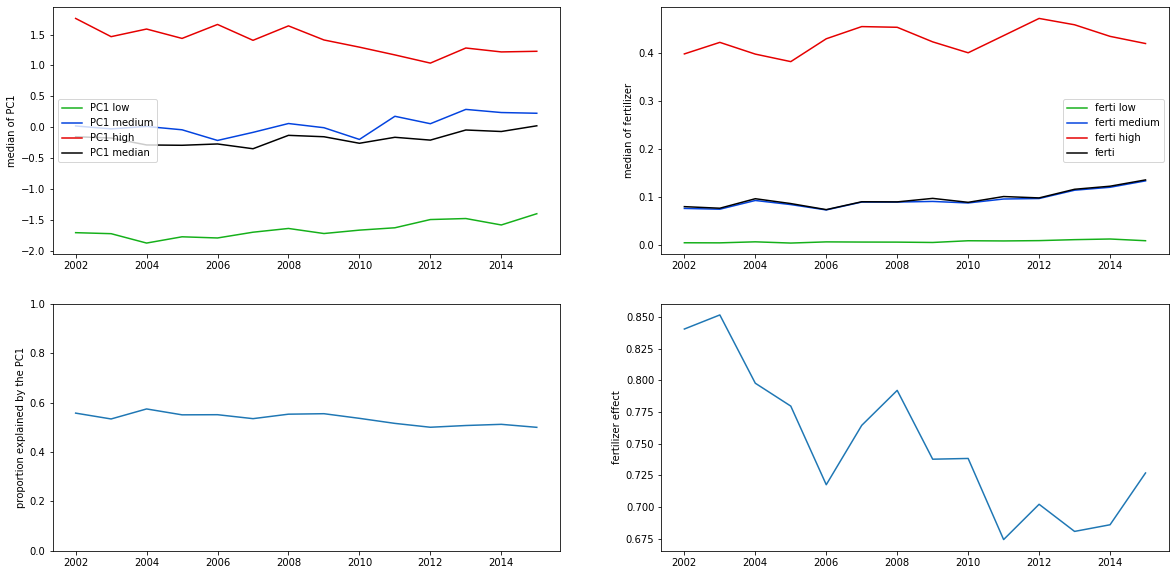

In [375]:
evolution_ferti = pd.DataFrame([years, PC1_low, PC1_medium, PC1_high, ferti_low, ferti_medium, ferti_high,ferti,PC1, proportion_explained, fertilizer_effect], ['year', 'PC1 low', 'PC1 medium', 'PC1 high','ferti low', 'ferti medium', 'ferti high','ferti','PC1 median', 'proportion explained', 'fertilizer_effect']).T
colors = ["green", "blue", "red"]

figure = plt.figure(figsize = (20,10))
ax1 = figure.add_subplot(2,2,1)
ax1.plot("year", "PC1 low", data=evolution_ferti, color=sns.xkcd_palette(colors)[0])
ax1.plot("year", "PC1 medium", data=evolution_ferti, color=sns.xkcd_palette(colors)[1])
ax1.plot("year", "PC1 high", data=evolution_ferti, color=sns.xkcd_palette(colors)[2])
ax1.plot("year", "PC1 median", data=evolution_ferti, color=sns.xkcd_rgb["black"])
ax1.set_ylabel('median of PC1')
ax1.legend(loc = 'center left')

ax2 = figure.add_subplot(2,2,2)
ax2.plot("year", "ferti low", data=evolution_ferti, color=sns.xkcd_palette(colors)[0])
ax2.plot("year", "ferti medium", data=evolution_ferti, color=sns.xkcd_palette(colors)[1])
ax2.plot("year", "ferti high", data=evolution_ferti, color=sns.xkcd_palette(colors)[2])
ax2.plot("year", "ferti", data=evolution_ferti, color=sns.xkcd_rgb["black"])
ax2.set_ylabel('median of fertilizer')
ax2.legend()

ax3 = figure.add_subplot(2,2,3)
ax3.plot("year", 'proportion explained', data=evolution_ferti)
ax3.set_ylabel('proportion explained by the PC1')
ax3.set_ylim([0,1])

ax4 = figure.add_subplot(2,2,4)
ax4.plot("year", 'fertilizer_effect', data=evolution_ferti)
ax4.set_ylabel('fertilizer effect')

In [121]:
emissions_fertilizer.head(2)

,domain_code,domain,area_code,area,element_code,element,item_code,item,year_code,year,unit,value,flag,flag_description,note,Value,Area,Year,emissions_ha
3,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5061,Synthetic Fertilizers,1961,1961,gigagrams,6.4546,EA,NaN,NaN,37700.0,Afghanistan,1961,0.000171
11,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5061,Synthetic Fertilizers,1962,1962,gigagrams,6.4546,EA,NaN,NaN,37760.0,Afghanistan,1962,0.000171


In [15]:
#emissions dataframe
emissions_year=pd.DataFrame(columns=['area'])
years = np.array([range(2002,2018)]).astype(str)

for year in range(2002,2018):#emissions_fertilizer.pivot_table(index=['year_code']).index :
    emissions=(emissions_fertilizer
            .query('`year_code` == @year')
            .pivot(index='area',columns = 'year_code',values='emissions_ha')
            .dropna(axis=0)
            .reset_index()
              )
    emissions.dropna(axis=0, inplace=True)
    emissions_year=emissions.merge(emissions_year, on='area',how='outer')

emissions_year.dropna(inplace = True)
emissions_year.columns = emissions_year.columns.astype(str)
emissions_year.head()

,area,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002
0,Afghanistan,0.023969,0.016459,0.003588,0.012578,0.005943,0.002906,0.003911,0.002201,0.002410,0.002457,0.002788,0.003484,0.003485,0.003804,0.003475,0.004193
1,Albania,0.216326,0.234306,0.202296,0.168811,0.166962,0.187756,0.198276,0.168136,0.182362,0.157102,0.181606,0.174816,0.223010,0.207790,0.215222,0.216383
2,Algeria,0.010962,0.010955,0.011584,0.011918,0.009971,0.011320,0.008780,0.009376,0.005787,0.003610,0.005731,0.006873,0.000640,0.016428,0.002762,0.004541
3,Angola,0.002912,0.002266,0.002780,0.003011,0.002229,0.002125,0.001792,0.001920,0.001159,0.000914,0.000625,0.000744,0.000413,0.000806,0.000200,0.000310
5,Argentina,0.042359,0.040350,0.026195,0.034035,0.034097,0.031781,0.037313,0.033754,0.021415,0.034092,0.043978,0.036031,0.029998,0.038264,0.036526,0.026809


In [16]:
emissions_year_2 = emissions_year.T
emissions_year_2.rename(columns=emissions_year_2.iloc[0], inplace = True)
emissions_year_2.drop(emissions_year_2.index[0], inplace = True)
emissions_year_2.head(2)

,Afghanistan,Albania,Algeria,Angola,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahrain,...,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zambia,Zimbabwe
2017,0.0239688,0.216326,0.010962,0.00291201,0.0423586,0.346791,0.0178737,0.278032,0.0117141,0.117372,...,0.374642,0.0172578,0.185407,0.0693639,0.182344,0.0757145,0.821523,0.00364279,0.0570535,0.0231491
2016,0.0164594,0.234306,0.0109554,0.00226551,0.0403497,0.563134,0.0183354,0.284856,0.0356616,0.155058,...,0.379605,0.0175109,0.187487,0.0699418,0.18226,0.0757145,0.821391,0.00517009,0.0509383,0.0231491


## Data frame for fertilizer emissions over the years per country:

In [17]:
emissions_year_2.dropna(axis = 'columns', inplace = True)
emissions_year_2.sort_index(inplace = True)
emissions_year_2.head(2)

,Afghanistan,Albania,Algeria,Angola,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahrain,...,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zambia,Zimbabwe
2002,0.0041928,0.216383,0.00454052,0.00031008,0.0268091,0.0728526,0.0141526,0.380255,0.0214266,0.580533,...,0.430031,0.00418835,0.171031,0.0112449,0.133408,0.0569351,0.775278,0.00308326,0.0115117,0.0295161
2003,0.00347454,0.215222,0.002762,0.000200285,0.0365263,0.0467112,0.0137009,0.668554,0.0170862,1.64415,...,0.428254,0.00500814,0.180292,0.0285039,0.134307,0.0575344,0.840039,0.00135109,0.0120635,0.0319635


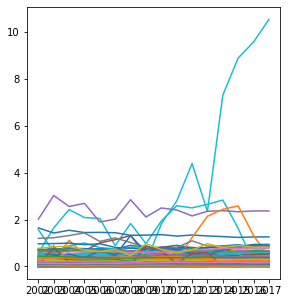

In [163]:
figure = plt.figure(figsize = (10,5))
ax1 = figure.add_subplot(1,2,1)


for x in range(0, emissions_year_2.shape[1]):
    ax1.plot(emissions_year_2.index, emissions_year_2.iloc[:,x])

In [64]:
emissions_year[emissions_year['2016'] > 2]

,area,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002
34,"China, Hong Kong SAR",10.542040,9.573560,8.896667,7.308961,2.346392,4.393059,2.788400,1.814345,0.163517,0.426000,0.749817,0.804683,0.998629,0.882443,0.622414,1.566629
51,Egypt,2.367983,2.367983,2.332931,2.379826,2.355047,2.155582,2.410167,2.495033,2.109501,2.847678,2.018415,1.897071,2.689774,2.558832,3.026404,2.017144


In [66]:
emissions_year_class = emissions_year.copy()
emissions_year_class['emissions_class'] = emissions_year_class['2016'].apply(lambda x: emissions_class(x, emissions_year_class['2016']))
emissions_year_class.head(2)

,area,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,emissions_class
0,Afghanistan,0.023969,0.016459,0.003588,0.012578,0.005943,0.002906,0.003911,0.002201,0.002410,0.002457,0.002788,0.003484,0.003485,0.003804,0.003475,0.004193,low
1,Albania,0.216326,0.234306,0.202296,0.168811,0.166962,0.187756,0.198276,0.168136,0.182362,0.157102,0.181606,0.174816,0.223010,0.207790,0.215222,0.216383,medium


In [69]:
emissions_low = emissions_year_class.query('emissions_class == "low"')
emissions_low.drop(['emissions_class'], axis = 1, inplace = True)
emissions_low_2 = emissions_low.T
emissions_low_2.rename(columns=emissions_low_2.iloc[0], inplace = True)
emissions_low_2.drop(emissions_low_2.index[0], inplace = True)
emissions_low_2.sort_index(inplace = True)


emissions_medium = emissions_year_class.query('emissions_class == "medium"')
emissions_medium.drop(['emissions_class'], axis = 1, inplace = True)
emissions_medium_2 = emissions_medium.T
emissions_medium_2.rename(columns=emissions_medium_2.iloc[0], inplace = True)
emissions_medium_2.drop(emissions_medium_2.index[0], inplace = True)
emissions_medium_2.sort_index(inplace = True)

emissions_high = emissions_year_class.query('emissions_class == "high"')
emissions_high.drop(['emissions_class'], axis = 1, inplace = True)
emissions_high_2 = emissions_high.T
emissions_high_2.rename(columns=emissions_high_2.iloc[0], inplace = True)
emissions_high_2.drop(emissions_high_2.index[0], inplace = True)
emissions_high_2.sort_index(inplace = True)

In [22]:
emissions_low

,area,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002
0,Afghanistan,0.023969,0.016459,0.003588,0.012578,0.005943,0.002906,0.003911,0.002201,0.002410,0.002457,0.002788,0.003484,0.003485,0.003804,0.003475,0.004193
2,Algeria,0.010962,0.010955,0.011584,0.011918,0.009971,0.011320,0.008780,0.009376,0.005787,0.003610,0.005731,0.006873,0.000640,0.016428,0.002762,0.004541
3,Angola,0.002912,0.002266,0.002780,0.003011,0.002229,0.002125,0.001792,0.001920,0.001159,0.000914,0.000625,0.000744,0.000413,0.000806,0.000200,0.000310
5,Argentina,0.042359,0.040350,0.026195,0.034035,0.034097,0.031781,0.037313,0.033754,0.021415,0.034092,0.043978,0.036031,0.029998,0.038264,0.036526,0.026809
7,Australia,0.017874,0.018335,0.020665,0.019915,0.019889,0.017902,0.017314,0.015899,0.013410,0.012916,0.012877,0.012733,0.013808,0.015490,0.013701,0.014153
9,Azerbaijan,0.011714,0.035662,0.005765,0.051366,0.034358,0.037281,0.030471,0.017349,0.026155,0.040261,0.022775,0.027626,0.023839,0.026668,0.017086,0.021427
17,Benin,0.000075,0.023177,0.000302,0.024126,0.008218,0.015382,0.007303,0.021360,0.010246,0.000649,0.001110,0.000021,0.000765,0.000270,0.002454,0.045188
19,Bhutan,0.009855,0.009846,0.011302,0.010914,0.009419,0.009642,0.010497,0.008515,0.019960,0.009584,0.009172,0.008591,0.009655,0.009041,0.009460,0.009447
20,Bolivia (Plurinational State of),0.002448,0.003444,0.003963,0.004078,0.004111,0.003303,0.003510,0.003090,0.002369,0.002320,0.002051,0.001515,0.002129,0.001103,0.001092,0.001045
26,Burkina Faso,0.031095,0.036081,0.027255,0.026032,0.026595,0.025352,0.016263,0.021972,0.015570,0.016355,0.013874,0.017980,0.020850,0.017592,0.015383,0.001205


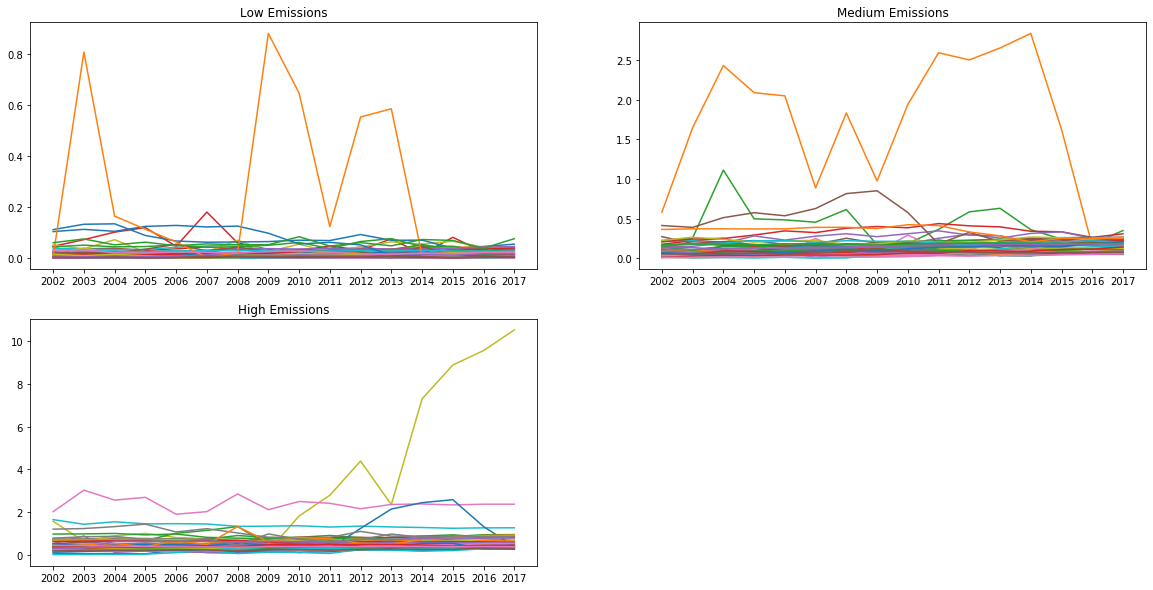

In [71]:
figure = plt.figure(figsize = (20,10))

ax1 = figure.add_subplot(2,2,1)
ax1.set_title('Low Emissions')
for x in range(0, emissions_low_2.shape[1]):
    ax1.plot(emissions_low_2.index, emissions_low_2.iloc[:,x])
    
ax2 = figure.add_subplot(2,2,2)
ax2.set_title('Medium Emissions')
for x in range(0, emissions_medium_2.shape[1]):
    ax2.plot(emissions_medium_2.index, emissions_medium_2.iloc[:,x])
    
ax3 = figure.add_subplot(2,2,3)
ax3.set_title('High Emissions')
for x in range(0, emissions_high_2.shape[1]):
    ax3.plot(emissions_high_2.index, emissions_high_2.iloc[:,x])

In [18]:
yield_pca = pd.read_pickle('yield_indic')
yield_pca.head(2)

,Area,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Afghanistan,0.263494,0.208613,0.192926,0.179725,0.191971,0.182814,0.162389,0.155492,0.134034,0.143281,0.172716,0.193963,0.171989,0.161094,0.159547
1,Albania,0.394228,0.319205,0.295479,0.332666,0.371833,0.345489,0.371913,0.371373,0.418766,0.428709,0.446074,0.447650,0.447010,0.440241,0.472243


In [19]:
ferti_year = pd.read_pickle('ferti_year')
ferti_year.head()

,Area,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002
0,Afghanistan,11.71,11.71,11.71,14.45,27.58,6.31,4.19,4.45,2.94,3.57,6.20,3.17,2.96,2.57,3.02
1,Albania,60.98,52.87,44.13,44.11,49.95,52.74,48.48,48.13,40.39,44.38,42.57,55.94,51.19,53.15,54.34
2,Algeria,11.53,11.83,12.25,7.79,7.89,7.51,8.43,5.69,2.75,4.37,5.23,0.49,12.62,2.07,3.42
3,Angola,4.89,4.91,5.32,3.94,3.89,3.28,3.96,2.44,2.21,1.51,1.85,1.03,2.00,0.50,0.81
4,Antigua and Barbuda,8.76,1.70,4.12,6.48,5.34,0.80,0.80,4.60,1.80,0.40,1.80,3.40,0.00,6.60,2.00


## Data frame for fertilizer evolution over the years per country:

In [104]:
ferti_year_2 = ferti_year.T
ferti_year_2.rename(columns=ferti_year_2.loc['Area'], inplace = True)
ferti_year_2.drop(ferti_year_2.index[0], inplace = True)
ferti_year_2.sort_index(inplace = True)
ferti_year_2.head(2)

,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,...,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zambia,Zimbabwe
2002,3.02,54.34,3.42,0.81,2,18.52,31.98,20.37,117.43,7.63,...,193.8,2.18,62.29,18.27,113.92,78.28,130.52,6.82,15.42,18.86
2003,2.57,53.15,2.07,0.5,6.6,24.95,21.15,19.69,205.95,6.1,...,197.09,2.59,66.16,46.19,113.92,99.11,138.45,3.29,14.72,20.67


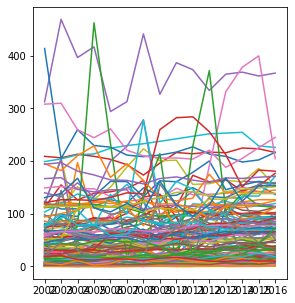

In [76]:
figure = plt.figure(figsize = (10,5))

ax1 = figure.add_subplot(1,2,1)
for x in range(0, ferti_year_2.shape[1]):
    ax1.plot(ferti_year_2.index, ferti_year_2.iloc[:,x])

Text(0.5, 1.0, 'emissions')

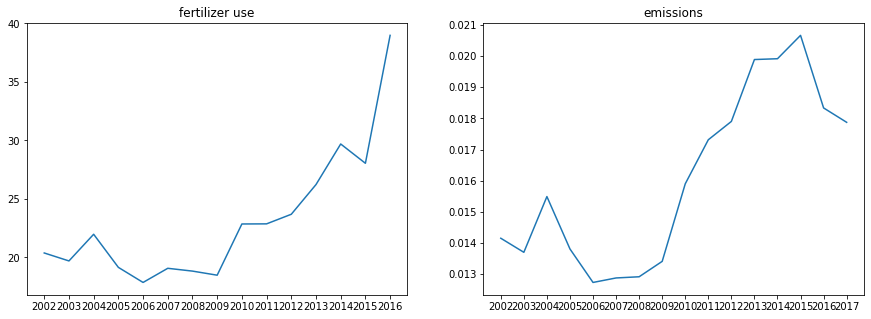

In [77]:
figure = plt.figure(figsize = (15,5))

ax1 = figure.add_subplot(1,2,1)
ax1.plot(ferti_year_2.index, ferti_year_2.loc[:,'Australia'])
ax1.set_title('fertilizer use')

ax2 = figure.add_subplot(1,2,2)
ax2.plot(emissions_year_2.index, emissions_year_2.loc[:,'Australia'])
ax2.set_title('emissions')

Text(0.5, 1.0, 'emissions')

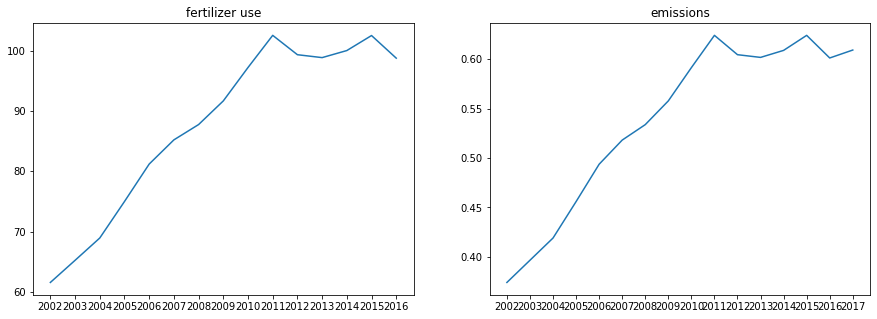

In [78]:
figure = plt.figure(figsize = (15,5))

ax1 = figure.add_subplot(1,2,1)
ax1.plot(ferti_year_2.index, ferti_year_2.loc[:,'India'])
ax1.set_title('fertilizer use')

ax2 = figure.add_subplot(1,2,2)
ax2.plot(emissions_year_2.index, emissions_year_2.loc[:,'India'])
ax2.set_title('emissions')

Text(0.5, 1.0, 'emissions')

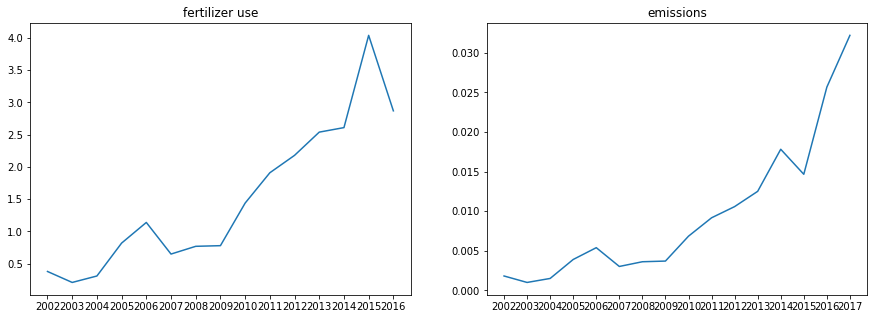

In [79]:
figure = plt.figure(figsize = (15,5))

ax1 = figure.add_subplot(1,2,1)
ax1.plot(ferti_year_2.index, ferti_year_2.loc[:,'Burundi'])
ax1.set_title('fertilizer use')

ax2 = figure.add_subplot(1,2,2)
ax2.plot(emissions_year_2.index, emissions_year_2.loc[:,'Burundi'])
ax2.set_title('emissions')

Text(0.5, 1.0, 'emissions')

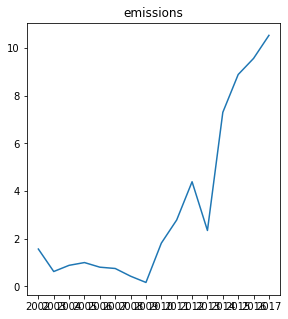

In [115]:
figure = plt.figure(figsize = (10,5))

#ax1 = figure.add_subplot(1,2,1)
#ax1.plot(ferti_year_2.index, ferti_year_2.loc[:,'China, Hong Kong SAR'])
#ax1.set_title('fertilizer use')

ax2 = figure.add_subplot(1,2,2)
ax2.plot(emissions_year_2.index, emissions_year_2.loc[:,'China, Hong Kong SAR'])
ax2.set_title('emissions')

In [102]:
emissions_year_2 = emissions_year_2.astype(float)
emissions_year_2.head(2)

,Afghanistan,Albania,Algeria,Angola,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahrain,...,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zambia,Zimbabwe
2002,0.0041928,0.216383,0.00454052,0.00031008,0.0268091,0.0728526,0.0141526,0.380255,0.0214266,0.580533,...,0.430031,0.00418835,0.171031,0.0112449,0.133408,0.0569351,0.775278,0.00308326,0.0115117,0.0295161
2003,0.00347454,0.215222,0.002762,0.000200285,0.0365263,0.0467112,0.0137009,0.668554,0.0170862,1.64415,...,0.428254,0.00500814,0.180292,0.0285039,0.134307,0.0575344,0.840039,0.00135109,0.0120635,0.0319635


In [105]:
ferti_year_2 = ferti_year_2.astype(float)
ferti_year_2.head(2)

,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,...,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zambia,Zimbabwe
2002,3.02,54.34,3.42,0.81,2,18.52,31.98,20.37,117.43,7.63,...,193.8,2.18,62.29,18.27,113.92,78.28,130.52,6.82,15.42,18.86
2003,2.57,53.15,2.07,0.5,6.6,24.95,21.15,19.69,205.95,6.1,...,197.09,2.59,66.16,46.19,113.92,99.11,138.45,3.29,14.72,20.67


In [161]:
emiss_corr = pd.merge(emissions_year_2, ferti_year_2, left_index = True, right_index = True)
emiss_corr.head(2)

,Afghanistan_x,Albania_x,Algeria_x,Angola_x,Argentina_x,Armenia_x,Australia_x,Austria_x,Azerbaijan_x,Bahrain,...,United Kingdom_y,United Republic of Tanzania_y,United States of America_y,Uruguay_y,Uzbekistan_y,Venezuela (Bolivarian Republic of)_y,Viet Nam_y,Yemen_y,Zambia_y,Zimbabwe_y
2002,0.004193,0.216383,0.004541,0.00031,0.026809,0.072853,0.014153,0.380255,0.021427,0.580533,...,193.8,2.18,62.29,18.27,113.92,78.28,130.52,6.82,15.42,18.86
2003,0.003475,0.215222,0.002762,0.00020,0.036526,0.046711,0.013701,0.668554,0.017086,1.644146,...,197.09,2.59,66.16,46.19,113.92,99.11,138.45,3.29,14.72,20.67


In [168]:
emiss_corr_matrix = emiss_corr.corr()
emiss_corr_matrix.head(2)

,Afghanistan_x,Albania_x,Algeria_x,Angola_x,Argentina_x,Armenia_x,Australia_x,Austria_x,Azerbaijan_x,Bahrain,...,United Kingdom_x,United Republic of Tanzania_x,United States of America_x,Uruguay_x,Uzbekistan_x,Venezuela (Bolivarian Republic of)_x,Viet Nam_x,Yemen_x,Zambia_x,Zimbabwe_x
Afghanistan_x,1.000000,0.284961,0.349980,0.509623,0.289389,0.757392,0.515686,0.084441,0.516911,-0.193699,...,0.048488,0.616878,0.428121,0.357080,0.544446,-0.033776,0.222493,0.293755,0.694196,-0.113134
Albania_x,0.284961,1.000000,-0.074841,-0.248462,0.015117,0.202431,0.008864,0.432005,-0.354202,-0.450003,...,0.533752,-0.177623,-0.064071,-0.382331,-0.145935,-0.435822,0.237132,-0.524668,0.103922,0.271215


In [169]:
emiss_corr_matrix = emiss_corr_matrix.iloc[:, ~emiss_corr_matrix.columns.str.endswith('_y')]
emiss_corr_matrix.head(2)

,Afghanistan_x,Albania_x,Algeria_x,Angola_x,Argentina_x,Armenia_x,Australia_x,Austria_x,Azerbaijan_x,Bahrain,...,United Kingdom_x,United Republic of Tanzania_x,United States of America_x,Uruguay_x,Uzbekistan_x,Venezuela (Bolivarian Republic of)_x,Viet Nam_x,Yemen_x,Zambia_x,Zimbabwe_x
Afghanistan_x,1.000000,0.284961,0.349980,0.509623,0.289389,0.757392,0.515686,0.084441,0.516911,-0.193699,...,0.048488,0.616878,0.428121,0.357080,0.544446,-0.033776,0.222493,0.293755,0.694196,-0.113134
Albania_x,0.284961,1.000000,-0.074841,-0.248462,0.015117,0.202431,0.008864,0.432005,-0.354202,-0.450003,...,0.533752,-0.177623,-0.064071,-0.382331,-0.145935,-0.435822,0.237132,-0.524668,0.103922,0.271215


In [170]:
emiss_corr_matrix[~emiss_corr_matrix.index.str.endswith('_y')].sort_index()

,Afghanistan_x,Albania_x,Algeria_x,Angola_x,Argentina_x,Armenia_x,Australia_x,Austria_x,Azerbaijan_x,Bahrain,...,United Kingdom_x,United Republic of Tanzania_x,United States of America_x,Uruguay_x,Uzbekistan_x,Venezuela (Bolivarian Republic of)_x,Viet Nam_x,Yemen_x,Zambia_x,Zimbabwe_x
Afghanistan_x,1.000000,0.284961,0.349980,0.509623,0.289389,0.757392,0.515686,0.084441,0.516911,-0.193699,...,0.048488,0.616878,0.428121,0.357080,0.544446,-0.033776,0.222493,0.293755,0.694196,-0.113134
Albania_x,0.284961,1.000000,-0.074841,-0.248462,0.015117,0.202431,0.008864,0.432005,-0.354202,-0.450003,...,0.533752,-0.177623,-0.064071,-0.382331,-0.145935,-0.435822,0.237132,-0.524668,0.103922,0.271215
Algeria_x,0.349980,-0.074841,1.000000,0.659850,0.191795,0.409113,0.678735,-0.274008,0.194544,0.313996,...,-0.027492,0.484740,0.554905,0.545768,0.397455,0.072565,0.333404,0.341037,0.583752,-0.393977
Angola_x,0.509623,-0.248462,0.659850,1.000000,-0.070496,0.604882,0.909676,-0.262136,0.312287,0.300715,...,-0.275618,0.833235,0.680391,0.802459,0.912714,0.425011,0.245910,0.296609,0.885166,-0.525414
Argentina_x,0.289389,0.015117,0.191795,-0.070496,1.000000,0.167685,-0.054919,0.010789,0.240391,0.055966,...,-0.157981,0.038730,0.392116,0.137350,-0.109129,-0.128448,-0.313197,0.457205,0.073257,0.000499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela (Bolivarian Republic of)_x,-0.033776,-0.435822,0.072565,0.425011,-0.128448,0.144139,0.176452,-0.488063,0.263277,0.091601,...,-0.564271,0.450019,-0.023989,0.451639,0.482579,1.000000,-0.280383,0.357150,0.269937,-0.205947
Viet Nam_x,0.222493,0.237132,0.333404,0.245910,-0.313197,0.204818,0.397636,0.249029,-0.250228,-0.154930,...,0.494062,0.382659,0.087984,0.127580,0.232273,-0.280383,1.000000,0.038768,0.327987,-0.004946
Yemen_x,0.293755,-0.524668,0.341037,0.296609,0.457205,0.156859,0.164927,-0.399827,0.524241,0.085680,...,-0.229681,0.459305,0.195968,0.497033,0.237577,0.357150,0.038768,1.000000,0.187166,-0.144007
Zambia_x,0.694196,0.103922,0.583752,0.885166,0.073257,0.802430,0.898245,-0.122684,0.214671,0.041103,...,-0.173535,0.881302,0.715741,0.661342,0.897191,0.269937,0.327987,0.187166,1.000000,-0.483789


In [199]:
correlation = pd.merge(emissions_year, ferti_year, left_on = 'area', right_on = 'Area',suffixes=('_emiss','_ferti'))
correlation.drop('Area', axis = 1, inplace = True)
correlation.head(2)

,area,2017,2016_emiss,2015_emiss,2014_emiss,2013_emiss,2012_emiss,2011_emiss,2010_emiss,2009_emiss,...,2011_ferti,2010_ferti,2009_ferti,2008_ferti,2007_ferti,2006_ferti,2005_ferti,2004_ferti,2003_ferti,2002_ferti
0,Afghanistan,0.023969,0.016459,0.003588,0.012578,0.005943,0.002906,0.003911,0.002201,0.002410,...,6.31,4.19,4.45,2.94,3.57,6.20,3.17,2.96,2.57,3.02
1,Albania,0.216326,0.234306,0.202296,0.168811,0.166962,0.187756,0.198276,0.168136,0.182362,...,52.74,48.48,48.13,40.39,44.38,42.57,55.94,51.19,53.15,54.34


In [211]:
ferti_corr = correlation.iloc[:,~correlation.columns.str.endswith('_emiss')] 
ferti_corr.columns = ferti_corr.columns.str.replace('_ferti', '')


emiss_corr = correlation.iloc[:,~correlation.columns.str.endswith('_ferti')] 
emiss_corr.columns = emiss_corr.columns.str.replace('_emiss', '')


emiss_corr = emiss_corr.T
emiss_corr.rename(columns=emiss_corr.loc['area'], inplace = True)
emiss_corr.columns += '_emiss'
emiss_corr.drop(emiss_corr.index[0], inplace = True)
emiss_corr.sort_index(inplace = True)
emiss_corr = emiss_corr.astype(float)

ferti_corr = ferti_corr.T
ferti_corr.rename(columns=ferti_corr.loc['area'], inplace = True)
ferti_corr.columns += '_ferti'
ferti_corr.drop(ferti_corr.index[0], inplace = True)
ferti_corr.sort_index(inplace = True)
ferti_corr = ferti_corr.astype(float)

In [212]:
ferti_corr.head()

,Afghanistan_ferti,Albania_ferti,Algeria_ferti,Angola_ferti,Argentina_ferti,Armenia_ferti,Australia_ferti,Austria_ferti,Azerbaijan_ferti,Bangladesh_ferti,...,United Kingdom_ferti,United Republic of Tanzania_ferti,United States of America_ferti,Uruguay_ferti,Uzbekistan_ferti,Venezuela (Bolivarian Republic of)_ferti,Viet Nam_ferti,Yemen_ferti,Zambia_ferti,Zimbabwe_ferti
2002,3.02,54.34,3.42,0.81,18.52,31.98,20.37,117.43,7.63,123.28,...,193.80,2.18,62.29,18.27,113.92,78.28,130.52,6.82,15.42,18.86
2003,2.57,53.15,2.07,0.50,24.95,21.15,19.69,205.95,6.10,109.00,...,197.09,2.59,66.16,46.19,113.92,99.11,138.45,3.29,14.72,20.67
2004,2.96,51.19,12.62,2.00,25.06,26.11,21.97,66.49,9.52,109.37,...,180.81,3.09,67.15,59.09,113.92,78.09,167.42,10.90,20.77,13.23
2005,3.17,55.94,0.49,1.03,18.89,20.30,19.14,70.34,8.51,114.03,...,173.65,2.95,65.63,51.59,113.92,80.16,111.26,2.59,18.70,12.10
2006,6.20,42.57,5.23,1.85,21.97,24.56,17.85,67.27,9.87,126.60,...,164.20,3.45,71.30,67.60,113.92,58.45,103.54,5.48,16.15,14.41


In [213]:
correlation_2 = pd.merge(emiss_corr, ferti_corr, left_index = True, right_index = True)
correlation_2.head(2)

,Afghanistan_emiss,Albania_emiss,Algeria_emiss,Angola_emiss,Argentina_emiss,Armenia_emiss,Australia_emiss,Austria_emiss,Azerbaijan_emiss,Bangladesh_emiss,...,United Kingdom_ferti,United Republic of Tanzania_ferti,United States of America_ferti,Uruguay_ferti,Uzbekistan_ferti,Venezuela (Bolivarian Republic of)_ferti,Viet Nam_ferti,Yemen_ferti,Zambia_ferti,Zimbabwe_ferti
2002,0.004193,0.216383,0.004541,0.00031,0.026809,0.072853,0.014153,0.380255,0.021427,0.744678,...,193.80,2.18,62.29,18.27,113.92,78.28,130.52,6.82,15.42,18.86
2003,0.003475,0.215222,0.002762,0.00020,0.036526,0.046711,0.013701,0.668554,0.017086,0.658293,...,197.09,2.59,66.16,46.19,113.92,99.11,138.45,3.29,14.72,20.67


In [267]:
matrix = correlation_2.corr()
matrix.head(2)

,Afghanistan_emiss,Albania_emiss,Algeria_emiss,Angola_emiss,Argentina_emiss,Armenia_emiss,Australia_emiss,Austria_emiss,Azerbaijan_emiss,Bangladesh_emiss,...,United Kingdom_ferti,United Republic of Tanzania_ferti,United States of America_ferti,Uruguay_ferti,Uzbekistan_ferti,Venezuela (Bolivarian Republic of)_ferti,Viet Nam_ferti,Yemen_ferti,Zambia_ferti,Zimbabwe_ferti
Afghanistan_emiss,1.000000,0.372315,0.356199,0.594920,0.451509,0.716969,0.457262,0.068265,0.034671,0.305024,...,-0.744341,-0.158869,-0.651376,-0.408034,-0.567779,-0.773818,-0.532715,-0.222313,0.154202,-0.700151
Albania_emiss,0.372315,1.000000,-0.025867,-0.124183,0.106277,0.271291,0.052799,0.422417,-0.410688,-0.312498,...,-0.097419,-0.297085,-0.290858,-0.479220,-0.285641,-0.147521,-0.071401,-0.603313,0.161627,-0.066819


In [268]:
matrix = matrix.iloc[:, ~matrix.columns.str.endswith('_ferti')]
matrix.head(2)

,Afghanistan_emiss,Albania_emiss,Algeria_emiss,Angola_emiss,Argentina_emiss,Armenia_emiss,Australia_emiss,Austria_emiss,Azerbaijan_emiss,Bangladesh_emiss,...,United Kingdom_emiss,United Republic of Tanzania_emiss,United States of America_emiss,Uruguay_emiss,Uzbekistan_emiss,Venezuela (Bolivarian Republic of)_emiss,Viet Nam_emiss,Yemen_emiss,Zambia_emiss,Zimbabwe_emiss
Afghanistan_emiss,1.000000,0.372315,0.356199,0.594920,0.451509,0.716969,0.457262,0.068265,0.034671,0.305024,...,-0.056722,0.674961,0.366310,0.353643,0.591622,0.045036,0.218114,0.145448,0.790591,-0.043508
Albania_emiss,0.372315,1.000000,-0.025867,-0.124183,0.106277,0.271291,0.052799,0.422417,-0.410688,-0.312498,...,0.483799,-0.051612,-0.029717,-0.321504,-0.044221,-0.397802,0.253677,-0.520217,0.223316,0.271470


In [269]:
matrix = matrix[~matrix.index.str.endswith('_emiss')]#.sort_index()
matrix.head()

,Afghanistan_emiss,Albania_emiss,Algeria_emiss,Angola_emiss,Argentina_emiss,Armenia_emiss,Australia_emiss,Austria_emiss,Azerbaijan_emiss,Bangladesh_emiss,...,United Kingdom_emiss,United Republic of Tanzania_emiss,United States of America_emiss,Uruguay_emiss,Uzbekistan_emiss,Venezuela (Bolivarian Republic of)_emiss,Viet Nam_emiss,Yemen_emiss,Zambia_emiss,Zimbabwe_emiss
Afghanistan_ferti,-0.055915,-0.172949,0.398288,0.480291,-0.163756,0.373306,0.579111,-0.092818,0.423151,0.235039,...,-0.136456,0.302148,0.670223,0.722425,0.447401,0.111683,0.121123,0.115097,0.307212,-0.585470
Albania_ferti,-0.619141,0.135406,-0.149836,-0.355904,-0.361672,-0.192972,-0.081260,0.121774,0.191849,-0.289647,...,0.299017,-0.362860,-0.115946,-0.221617,-0.276869,-0.148765,0.014558,-0.128313,-0.401795,0.067264
Algeria_ferti,-0.021140,-0.126739,0.779659,0.494117,-0.044297,0.316585,0.608033,-0.231726,0.302065,0.246555,...,-0.000607,0.341930,0.432925,0.406806,0.334738,0.085264,0.306577,0.298703,0.331392,-0.331323
Angola_ferti,0.000016,-0.311862,0.535347,0.667323,-0.165745,0.432912,0.701614,-0.297401,0.429967,0.536584,...,-0.251722,0.534661,0.519014,0.639928,0.621180,0.386052,0.146502,0.330135,0.450183,-0.469092
Argentina_ferti,-0.595201,-0.142542,-0.138445,-0.524665,0.182381,-0.341971,-0.320917,0.110071,0.352070,-0.462121,...,0.147151,-0.487077,-0.033277,-0.241140,-0.515483,-0.254729,-0.249608,0.210983,-0.566726,0.103991


In [270]:
matrix.iloc[1][1]

0.1354064012026944

In [271]:
emiss_ferti_corr = pd.DataFrame(correlation.area)
emiss_ferti_corr['correlation'] = 0

for i in range(0, matrix.shape[0], 1):
    x = matrix.iloc[i][i]
    emiss_ferti_corr['correlation'][i] += x

emiss_ferti_corr.head()

/Users/AmaraSlaymaker/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,area,correlation
0,Afghanistan,0
1,Albania,0
2,Algeria,0
3,Angola,0
4,Argentina,0


In [260]:
emiss_ferti_corr['correlation'][1]

0

In [250]:
matrix.iloc[1][1] = 2

In [251]:
matrix.iloc[1][1]

2.0

## Data frame for pca evolution plot:

In [223]:
yield_pca_2 = yield_pca.T
yield_pca_2.rename(columns=yield_pca_2.loc['Area'], inplace = True)
yield_pca_2.drop(yield_pca_2.index[0], inplace = True)
yield_pca_2.sort_index(inplace = True)
yield_pca_2.dropna(axis = 'columns', inplace = True)
yield_pca_2.head()

,Afghanistan,Albania,Algeria,Angola,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,...,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zambia,Zimbabwe
2002,0.263494,0.394228,0.267123,0.16859,0.541703,0.377129,0.50388,0.757574,0.314859,0.316668,...,0.878847,0.144382,0.789424,0.341718,0.383109,0.386638,0.30421,0.222389,0.131673,0.100226
2003,0.208613,0.319205,0.257981,0.103734,0.547322,0.315774,0.40079,0.700428,0.298395,0.268817,...,0.879722,0.032286,0.795847,0.353248,0.341305,0.364923,0.278476,0.161158,0.0685054,0.0620404
2004,0.192926,0.295479,0.234186,0.0856617,0.458804,0.357631,0.437435,0.752519,0.269072,0.251786,...,0.752708,0.0480105,0.774528,0.308278,0.344418,0.294609,0.257053,0.193008,0.0705853,0.0706497
2005,0.179725,0.332666,0.242017,0.093193,0.513677,0.441694,0.438336,0.733729,0.300314,0.250049,...,0.838472,0.0427564,0.774551,0.343016,0.371507,0.291204,0.272029,0.195538,0.0785632,0.0305754
2006,0.191971,0.371833,0.25412,0.0951183,0.534109,0.410915,0.470639,0.758338,0.311396,0.266016,...,0.841098,0.0555473,0.823411,0.40094,0.439539,0.314352,0.297754,0.228942,0.0778842,0.043294


In [215]:
emiss_pca = pd.merge(yield_pca, emissions_year, left_on = 'Area', right_on = 'area',suffixes=('_pca','_emiss'))
emiss_pca.drop('area', axis = 1, inplace = True)
emiss_pca.head()

,Area,2002_pca,2003_pca,2004_pca,2005_pca,2006_pca,2007_pca,2008_pca,2009_pca,2010_pca,...,2011_emiss,2010_emiss,2009_emiss,2008_emiss,2007_emiss,2006_emiss,2005_emiss,2004_emiss,2003_emiss,2002_emiss
0,Afghanistan,0.263494,0.208613,0.192926,0.179725,0.191971,0.182814,0.162389,0.155492,0.134034,...,0.003911,0.002201,0.002410,0.002457,0.002788,0.003484,0.003485,0.003804,0.003475,0.004193
1,Albania,0.394228,0.319205,0.295479,0.332666,0.371833,0.345489,0.371913,0.371373,0.418766,...,0.198276,0.168136,0.182362,0.157102,0.181606,0.174816,0.223010,0.207790,0.215222,0.216383
2,Algeria,0.267123,0.257981,0.234186,0.242017,0.254120,0.213298,0.232459,0.261738,0.281083,...,0.008780,0.009376,0.005787,0.003610,0.005731,0.006873,0.000640,0.016428,0.002762,0.004541
3,Angola,0.168590,0.103734,0.085662,0.093193,0.095118,0.116208,0.118346,0.102838,0.108617,...,0.001792,0.001920,0.001159,0.000914,0.000625,0.000744,0.000413,0.000806,0.000200,0.000310
4,Argentina,0.541703,0.547322,0.458804,0.513677,0.534109,0.513240,0.501942,0.377790,0.498108,...,0.037313,0.033754,0.021415,0.034092,0.043978,0.036031,0.029998,0.038264,0.036526,0.026809


In [216]:
pca = emiss_pca.iloc[:,~emiss_pca.columns.str.endswith('_emiss')] 
pca.columns = pca.columns.str.replace('_pca', '')

emiss = emiss_pca.iloc[:,~emiss_pca.columns.str.endswith('_pca')] 
emiss.columns = pca.columns.str.replace('_emiss', '')


emiss = emiss.T
emiss.rename(columns=emiss.loc['Area'], inplace = True)
emiss.columns += '_emiss'
emiss.drop(emiss.index[0], inplace = True)
emiss.sort_index(inplace = True)

pca = pca.T
pca.rename(columns=pca.loc['Area'], inplace = True)
pca.columns += '_pca'
pca.drop(pca.index[0], inplace = True)
pca.sort_index(inplace = True)

In [217]:
pca.head(2)

,Afghanistan_pca,Albania_pca,Algeria_pca,Angola_pca,Argentina_pca,Armenia_pca,Australia_pca,Austria_pca,Azerbaijan_pca,Bangladesh_pca,...,United Kingdom_pca,United Republic of Tanzania_pca,United States of America_pca,Uruguay_pca,Uzbekistan_pca,Venezuela (Bolivarian Republic of)_pca,Viet Nam_pca,Yemen_pca,Zambia_pca,Zimbabwe_pca
2002,0.263494,0.394228,0.267123,0.16859,0.541703,0.377129,0.50388,0.757574,0.314859,0.223946,...,0.878847,0.144382,0.789424,0.341718,0.383109,0.386638,0.30421,0.222389,0.131673,0.100226
2003,0.208613,0.319205,0.257981,0.103734,0.547322,0.315774,0.40079,0.700428,0.298395,0.174179,...,0.879722,0.032286,0.795847,0.353248,0.341305,0.364923,0.278476,0.161158,0.0685054,0.0620404


In [218]:
emiss.head(2)

,Afghanistan_emiss,Albania_emiss,Algeria_emiss,Angola_emiss,Argentina_emiss,Armenia_emiss,Australia_emiss,Austria_emiss,Azerbaijan_emiss,Bangladesh_emiss,...,United Kingdom_emiss,United Republic of Tanzania_emiss,United States of America_emiss,Uruguay_emiss,Uzbekistan_emiss,Venezuela (Bolivarian Republic of)_emiss,Viet Nam_emiss,Yemen_emiss,Zambia_emiss,Zimbabwe_emiss
2002,0.0239688,0.216326,0.010962,0.00291201,0.0423586,0.346791,0.0178737,0.278032,0.0117141,0.871482,...,0.374642,0.0172578,0.185407,0.0693639,0.182344,0.0757145,0.821523,0.00364279,0.0570535,0.0231491
2003,0.0164594,0.234306,0.0109554,0.00226551,0.0403497,0.563134,0.0183354,0.284856,0.0356616,0.822994,...,0.379605,0.0175109,0.187487,0.0699418,0.18226,0.0757145,0.821391,0.00517009,0.0509383,0.0231491


## Final Data Frame:

In [222]:
emiss_pca_df = pd.merge(emiss, pca, left_index = True, right_index = True)
emiss_pca_df.head(2)

,Afghanistan_emiss,Albania_emiss,Algeria_emiss,Angola_emiss,Argentina_emiss,Armenia_emiss,Australia_emiss,Austria_emiss,Azerbaijan_emiss,Bangladesh_emiss,...,United Kingdom_pca,United Republic of Tanzania_pca,United States of America_pca,Uruguay_pca,Uzbekistan_pca,Venezuela (Bolivarian Republic of)_pca,Viet Nam_pca,Yemen_pca,Zambia_pca,Zimbabwe_pca
2002,0.0239688,0.216326,0.010962,0.00291201,0.0423586,0.346791,0.0178737,0.278032,0.0117141,0.871482,...,0.878847,0.144382,0.789424,0.341718,0.383109,0.386638,0.30421,0.222389,0.131673,0.100226
2003,0.0164594,0.234306,0.0109554,0.00226551,0.0403497,0.563134,0.0183354,0.284856,0.0356616,0.822994,...,0.879722,0.032286,0.795847,0.353248,0.341305,0.364923,0.278476,0.161158,0.0685054,0.0620404


## Data frame for efficiency

In [124]:
emissions_year_ee = emissions_year.set_index('area')
emissions_year_ee.astype(float)
emissions_year_ee.head()

,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002
area,,,,,,,,,,,,,,,,
Afghanistan,0.023969,0.016459,0.003588,0.012578,0.005943,0.002906,0.003911,0.002201,0.002410,0.002457,0.002788,0.003484,0.003485,0.003804,0.003475,0.004193
Albania,0.216326,0.234306,0.202296,0.168811,0.166962,0.187756,0.198276,0.168136,0.182362,0.157102,0.181606,0.174816,0.223010,0.207790,0.215222,0.216383
Algeria,0.010962,0.010955,0.011584,0.011918,0.009971,0.011320,0.008780,0.009376,0.005787,0.003610,0.005731,0.006873,0.000640,0.016428,0.002762,0.004541
Angola,0.002912,0.002266,0.002780,0.003011,0.002229,0.002125,0.001792,0.001920,0.001159,0.000914,0.000625,0.000744,0.000413,0.000806,0.000200,0.000310
Argentina,0.042359,0.040350,0.026195,0.034035,0.034097,0.031781,0.037313,0.033754,0.021415,0.034092,0.043978,0.036031,0.029998,0.038264,0.036526,0.026809


In [125]:
yield_pca_ee = yield_pca.set_index('Area')
yield_pca_ee.astype(float)
yield_pca_ee.head(5)

,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Area,,,,,,,,,,,,,,,
Afghanistan,0.263494,0.208613,0.192926,0.179725,0.191971,0.182814,0.162389,0.155492,0.134034,0.143281,0.172716,0.193963,0.171989,0.161094,0.159547
Albania,0.394228,0.319205,0.295479,0.332666,0.371833,0.345489,0.371913,0.371373,0.418766,0.428709,0.446074,0.447650,0.447010,0.440241,0.472243
Algeria,0.267123,0.257981,0.234186,0.242017,0.254120,0.213298,0.232459,0.261738,0.281083,0.305053,0.342455,0.352380,0.326843,0.330635,0.347874
Angola,0.168590,0.103734,0.085662,0.093193,0.095118,0.116208,0.118346,0.102838,0.108617,0.130947,0.087722,0.128989,0.126811,0.124678,0.128993
Argentina,0.541703,0.547322,0.458804,0.513677,0.534109,0.513240,0.501942,0.377790,0.498108,0.484524,0.476022,0.477465,0.469749,0.467691,0.470973


In [126]:
ee = yield_pca.copy()

years = np.array([range(2002,2017)]).astype(str)

for x in years:
    year = x
    ee[year]= yield_pca[year] /  emissions_year[year]
ee

,Area,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Afghanistan,62.844579,60.040455,50.723176,51.576856,55.098897,65.561382,66.086266,64.513957,60.889465,36.634981,59.443181,32.638396,13.674038,44.893391,9.693366
1,Albania,1.821897,1.483144,1.422013,1.491710,2.126993,1.902411,2.367335,2.036459,2.490641,2.162186,2.375813,2.681143,2.647989,2.176222,2.015498
2,Algeria,58.830884,93.403830,14.255723,378.170719,36.976264,37.219408,64.397513,45.228437,29.978852,34.743115,30.253521,35.342041,27.423990,28.542702,31.753806
3,Angola,543.698805,517.934101,106.344214,225.826097,127.792417,186.002677,129.436114,88.718379,56.570613,73.056948,41.275985,57.870531,42.113951,44.845914,56.938045
4,Argentina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,Yemen,0.286851,0.191846,0.223894,0.276478,0.361210,0.306053,0.464369,0.203768,0.311703,0.376039,0.333774,0.230612,0.245971,0.225549,0.261178
163,Zambia,42.705710,50.703729,15.184780,72.575810,31.950287,11.928424,16.893486,17.987269,11.164357,23.560099,23.278224,11.695762,11.161631,319.405442,14.854671
164,Zimbabwe,8.706432,5.142830,4.164726,2.088093,3.140529,3.348894,2.163361,1.802546,1.693674,0.847326,1.544007,1.312987,1.094977,0.826034,0.809623
165,South Sudan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.379200,3.211258,2.032725,NaN,NaN


In [127]:
ee = ee.T
ee.rename(columns=ee.loc['Area'], inplace = True)
ee.drop(ee.index[0], inplace = True)
ee.sort_index(inplace = True)
ee.dropna(axis = 1, inplace = True)
ee.head()

,Afghanistan,Albania,Algeria,Angola,Armenia,Australia,Austria,Azerbaijan,Bahamas,Barbados,...,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zambia,Zimbabwe
2002,62.8446,1.8219,58.8309,543.699,14.0672,6.91644,53.5291,0.828021,14.7792,0.479504,...,2.41898,0.335747,188.481,1.99799,34.0695,2.89817,5.34311,0.286851,42.7057,8.70643
2003,60.0405,1.48314,93.4038,517.934,8.64511,8.58017,51.1229,0.446329,15.733,0.147411,...,2.3705,0.0753898,158.911,1.95931,11.974,2.71709,4.84016,0.191846,50.7037,5.14283
2004,50.7232,1.42201,14.2557,106.344,9.34631,7.73449,48.5803,1.24395,9.44165,0.0879983,...,2.02824,0.119536,122.401,1.73041,9.3708,2.57492,4.1942,0.223894,15.1848,4.16473
2005,51.5769,1.49171,378.171,225.826,14.7243,10.6327,53.1368,1.30624,10.4891,0.103415,...,2.27147,0.111983,126.548,1.99249,11.5543,2.28622,4.13689,0.276478,72.5758,2.08809
2006,55.0989,2.12699,36.9763,127.792,11.4044,2.21188,59.5549,1.41094,9.62907,0.113769,...,2.26603,0.152292,115.008,2.20619,10.3735,2.37393,5.49358,0.36121,31.9503,3.14053


## Data set of "efficiency"
(I didvided PCA1 by "emissions-ha")

In [101]:
ee['mean'] = ee.mean(axis=1)
ee.head(5)

,Afghanistan,Albania,Algeria,Angola,Armenia,Australia,Austria,Azerbaijan,Bahamas,Barbados,...,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zambia,Zimbabwe,mean
2002,62.8446,1.8219,58.8309,543.699,14.0672,6.91644,53.5291,0.828021,14.7792,0.479504,...,0.335747,188.481,1.99799,34.0695,2.89817,5.34311,0.286851,42.7057,8.70643,65.041750
2003,60.0405,1.48314,93.4038,517.934,8.64511,8.58017,51.1229,0.446329,15.733,0.147411,...,0.0753898,158.911,1.95931,11.974,2.71709,4.84016,0.191846,50.7037,5.14283,120.593473
2004,50.7232,1.42201,14.2557,106.344,9.34631,7.73449,48.5803,1.24395,9.44165,0.0879983,...,0.119536,122.401,1.73041,9.3708,2.57492,4.1942,0.223894,15.1848,4.16473,67.470883
2005,51.5769,1.49171,378.171,225.826,14.7243,10.6327,53.1368,1.30624,10.4891,0.103415,...,0.111983,126.548,1.99249,11.5543,2.28622,4.13689,0.276478,72.5758,2.08809,87.737119
2006,55.0989,2.12699,36.9763,127.792,11.4044,2.21188,59.5549,1.41094,9.62907,0.113769,...,0.152292,115.008,2.20619,10.3735,2.37393,5.49358,0.36121,31.9503,3.14053,123.950218


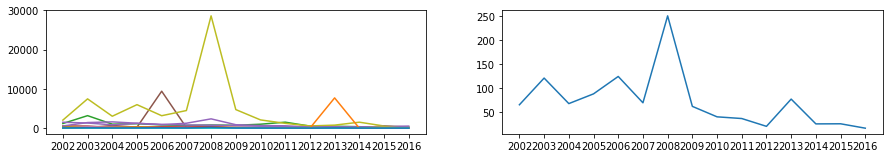

In [86]:
figure = plt.figure(figsize = (15,5))

ax1 = figure.add_subplot(2,2,1)
for x in range(0, ee.shape[1]):
    ax1.plot(ee.index, ee.iloc[:,x])

ax2 = figure.add_subplot(2,2,2)
ax2.plot(ee.index, ee['mean'])

Text(0.5, 1.0, 'Spain')

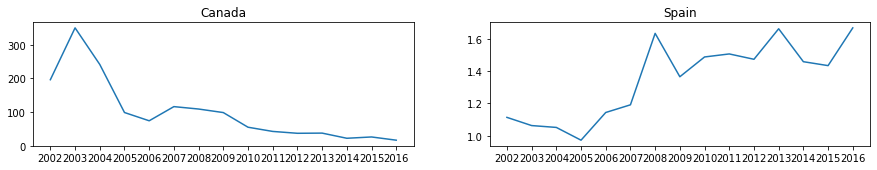

In [100]:
figure = plt.figure(figsize = (15,5))

ax1 = figure.add_subplot(2,2,1)
ax1.plot(ee.index, ee['Canada'])
ax1.set_title('Canada')

ax2 = figure.add_subplot(2,2,2)
ax2.plot(ee.index, ee['Spain'])
ax2.set_title('Spain')